The only purpose of this notebook is to find important features using LightGBM.

In [1]:
LOCAL = True
data_fpath = '../data/raw/' if LOCAL else '/kaggle/input/protein-localization/'
data_eng_fpath = '../data/intermediate/' if LOCAL else '../input/data-engineering/'
out_fpath = '../data/intermediate/' if LOCAL else ''

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import data_tools

In [3]:
from datetime import datetime
import pickle

import lightgbm as lgb
import pandas as pd
import numpy as np

SEED = 42

In [4]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


from imblearn.over_sampling import RandomOverSampler

In [5]:
from imblearn.over_sampling import RandomOverSampler

In [6]:
# Use the accuracy metric
def accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'acc.', accuracy_score(y_true, preds), True

def balanced_accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'bal. acc.', balanced_accuracy_score(y_true, preds), True

def f1_weighted(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='weighted'), True

def f1_macro(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='macro'), True

## Load Training DataFrame

In [7]:
X = pd.read_pickle(f"{data_eng_fpath}X.pkl")
y = pd.read_pickle(f"{data_eng_fpath}y.pkl")
X.shape, y.shape

((862, 478), (862,))

In [8]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,interaction_max,interaction_pos,ppi_gen_phys_count,max_corr_ppi,mode_localization,interaction_max2,interaction_count,interaction_min,interaction_mean,interaction_sum
0,Non-Essential,No,No,No,No,No,No,No,No,No,...,0.000000,0,0,460,unknown,0.000000,0,0.000000,0.000000,0.000000
1,Non-Essential,No,No,No,No,No,No,No,No,No,...,0.000000,0,0,460,unknown,0.000000,0,0.000000,0.000000,0.000000
2,Non-Essential,No,No,No,Yes,No,No,No,No,No,...,0.000000,0,0,460,unknown,0.000000,0,0.000000,0.000000,0.000000
3,Non-Essential,No,No,No,No,No,No,No,No,No,...,0.646193,1,0,658,11,0.000000,2,-0.063563,0.000676,0.582630
4,Essential,No,No,No,No,No,No,No,No,No,...,0.723051,4,0,736,0,0.709248,7,-0.483302,0.001453,1.252315


## Load Competition Data
* Note that data engineering pipeline drops labels, so we'll need thos

In [9]:
testdf = pd.read_csv(f"{data_fpath}test.csv", header=None)

In [10]:
X_kaggle = pd.read_pickle(f"{data_eng_fpath}X_kaggle.pkl")
X_kaggle.shape

(381, 478)

## Split Data

In [11]:
ros = RandomOverSampler(sampling_strategy={i : 3 for i in range(12, 15)}, random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=SEED)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)
# X_train.shape, X_val.shape, X_test.shape
X_train.shape, X_test.shape

((606, 478), (261, 478))

### LightGBM

In [13]:
N_ESTIMATORS = 200  # default is 100
hyper_params = {
    'boosting_type': 'gbdt',
    'random_state' : SEED,
    'objective' : 'multiclass',
#     'zero_as_missing' : True,
    'metric' : 'None',

    'reg_alpha': 0,
    'reg_lambda' : 0,
    'num_leaves': 400,
    'max_depth' : 8,
    'colsample_bytree' : 0.8,
    'subsample' : 0.9,
    'min_child_samples': 5,
    'class_weight' : {
        1 : 1.3,
    },

    # Training Parameters
    'learning_rate' : 0.01,
    'n_estimators': N_ESTIMATORS,
#     'first_metric_only' : True,
}
# model = lgb.LGBMClassifier(**hyper_params)
model = lgb.LGBMClassifier()
model.set_params(**hyper_params)

LGBMClassifier(class_weight={1: 1.3}, colsample_bytree=0.8, learning_rate=0.01,
               max_depth=8, metric='None', min_child_samples=5,
               n_estimators=200, num_leaves=400, objective='multiclass',
               random_state=42, reg_alpha=0, reg_lambda=0, subsample=0.9)

In [14]:
fit_params={
    "early_stopping_rounds": 200, 
    "eval_metric" : [
        accuracy,
#         'logloss',
        f1_macro,
#         balanced_accuracy,
    ],
    "eval_set" : [(X_train, y_train), (X_test, y_test)], # [(X_train, y_train), (X_val, y_val)],
    'eval_names': ['train', 'validation'],
    'verbose': N_ESTIMATORS // 10,
    
}
model.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 200 rounds
[20]	train's acc.: 0.556106	train's f1: 0.0929118	validation's acc.: 0.521073	validation's f1: 0.081783
[40]	train's acc.: 0.768977	train's f1: 0.634716	validation's acc.: 0.582375	validation's f1: 0.179809
[60]	train's acc.: 0.876238	train's f1: 0.764973	validation's acc.: 0.62069	validation's f1: 0.265283
[80]	train's acc.: 0.912541	train's f1: 0.924888	validation's acc.: 0.662835	validation's f1: 0.420893
[100]	train's acc.: 0.919142	train's f1: 0.916792	validation's acc.: 0.681992	validation's f1: 0.443754
[120]	train's acc.: 0.927393	train's f1: 0.923166	validation's acc.: 0.689655	validation's f1: 0.44494
[140]	train's acc.: 0.937294	train's f1: 0.932111	validation's acc.: 0.678161	validation's f1: 0.43635
[160]	train's acc.: 0.943894	train's f1: 0.939921	validation's acc.: 0.685824	validation's f1: 0.440015
[180]	train's acc.: 0.948845	train's f1: 0.941589	validation's acc.: 0.685824	validation's f1: 0.437987
[200]	tr

LGBMClassifier(class_weight={1: 1.3}, colsample_bytree=0.8, learning_rate=0.01,
               max_depth=8, metric='None', min_child_samples=5,
               n_estimators=200, num_leaves=400, objective='multiclass',
               random_state=42, reg_alpha=0, reg_lambda=0, subsample=0.9)

In [15]:
y_pred = pd.Series(model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       110
           1       0.53      0.67      0.60        58
           2       0.76      0.62      0.68        21
           3       0.69      0.65      0.67        17
           4       0.20      0.08      0.11        13
           5       0.53      0.69      0.60        13
           6       1.00      0.18      0.31        11
           7       0.33      0.20      0.25         5
           8       1.00      0.20      0.33         5
           9       1.00      0.33      0.50         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1

    accuracy                           0.69       261
   macro avg       0.59      0.44      0.46       261
weighted avg       0.69   

In [16]:
y_pred.value_counts()

0     123
1      73
2      17
5      17
3      16
4       5
7       3
6       2
8       1
9       1
10      1
13      1
14      1
dtype: int64

# Full model fit

In [17]:
hyper_params['n_estimators'] = 200
hyper_params['learning_rate'] = 0.01

full_model = lgb.LGBMClassifier()
full_model.set_params(**hyper_params)
full_fit_params={
    "early_stopping_rounds": 10, 
    "eval_metric" : [
        f1_macro,
        balanced_accuracy,
        accuracy
    ],
    "eval_set" : [(X, y)],
    'eval_names': ['train'],
    'verbose': hyper_params['n_estimators'] // 10,
    
}
full_model.fit(X, y, **full_fit_params)

Training until validation scores don't improve for 10 rounds
[20]	train's f1: 0.0900853	train's bal. acc.: 0.103637	train's acc.: 0.547564
[40]	train's f1: 0.53807	train's bal. acc.: 0.445137	train's acc.: 0.74942
[60]	train's f1: 0.746537	train's bal. acc.: 0.687349	train's acc.: 0.856148
[80]	train's f1: 0.846542	train's bal. acc.: 0.803308	train's acc.: 0.893271
[100]	train's f1: 0.855992	train's bal. acc.: 0.818763	train's acc.: 0.908353
[120]	train's f1: 0.862051	train's bal. acc.: 0.827392	train's acc.: 0.917633
[140]	train's f1: 0.866395	train's bal. acc.: 0.833069	train's acc.: 0.929234
[160]	train's f1: 0.91303	train's bal. acc.: 0.903694	train's acc.: 0.929234
[180]	train's f1: 0.915818	train's bal. acc.: 0.907836	train's acc.: 0.935035
[200]	train's f1: 0.927947	train's bal. acc.: 0.927896	train's acc.: 0.941995
Did not meet early stopping. Best iteration is:
[144]	train's f1: 0.933205	train's bal. acc.: 0.899736	train's acc.: 0.930394


LGBMClassifier(class_weight={1: 1.3}, colsample_bytree=0.8, learning_rate=0.01,
               max_depth=8, metric='None', min_child_samples=5,
               n_estimators=200, num_leaves=400, objective='multiclass',
               random_state=42, reg_alpha=0, reg_lambda=0, subsample=0.9)

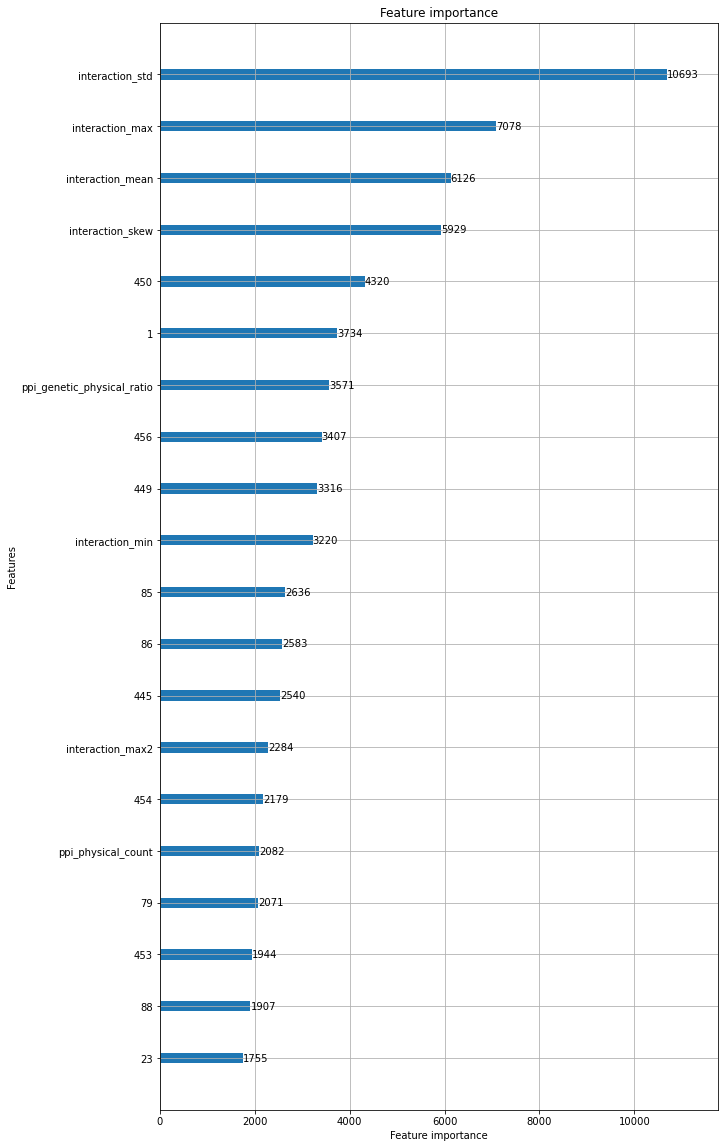

In [18]:
lgb.plot_importance(full_model, figsize=(10, 20), max_num_features=20);

In [19]:
important_feats = np.array(full_model.feature_name_)[full_model.feature_importances_ > 0]
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
important_feats = [int(feat) if RepresentsInt(feat) else feat for feat in important_feats]

## Reduced Feature Set

In [20]:
X_reduced = X[important_feats]
X_kaggle_reduced = X_kaggle[important_feats]
X_reduced.shape, X_kaggle_reduced.shape

((862, 88), (381, 88))

In [21]:
with open(f'{out_fpath}important_feats.pkl', 'wb') as f:
    pickle.dump(important_feats, f)

In [22]:
print(important_feats)

[1, 5, 8, 10, 11, 12, 14, 15, 17, 19, 20, 21, 22, 23, 25, 35, 38, 39, 42, 47, 49, 51, 54, 56, 59, 60, 65, 68, 69, 71, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 102, 137, 138, 156, 175, 197, 252, 298, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 'ppi_genetic_physical_ratio', 'ppi_physical_count', 'ppi_dom_type', 'ppi_genetic_count', 'strongest_localization', 'interaction_neg', 'interaction_skew', 'interaction_std', 'interaction_max3', 'interaction_max', 'interaction_pos', 'ppi_gen_phys_count', 'mode_localization', 'interaction_max2', 'interaction_count', 'interaction_min', 'interaction_mean', 'interaction_sum']
